# Intro

In [1]:
!pip install tensorflow

In [2]:
!pip install joblib

In [3]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from PIL import Image
from shutil import copy2
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, f1_score

In [4]:
# pake zip dataset drive
import zipfile
import gdown

url = "https://drive.google.com/uc?export=download&id=1yjuT0USeyqQmhoIuboWg9QWVoLgQkgjS"
output = "Motif_Batik_Dataset.zip"
gdown.download(url, output, quiet=False)

zip_ref = zipfile.ZipFile("/content/Motif_Batik_Dataset.zip", 'r')
zip_ref.extractall("dataset")
zip_ref.close()

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1yjuT0USeyqQmhoIuboWg9QWVoLgQkgjS
From (redirected): https://drive.google.com/uc?export=download&id=1yjuT0USeyqQmhoIuboWg9QWVoLgQkgjS&confirm=t&uuid=6b3584d4-7fb6-49a5-a497-c319647d68c8
To: /content/Motif_Batik_Dataset.zip
100%|██████████| 397M/397M [00:08<00:00, 48.0MB/s]


# Split data train val test

In [5]:
train_dir = r'/content/dataset/data/train'
def check_image_shapes(directory):
    shapes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    shapes.append(img.size)
    return shapes

# Fungsi untuk menghitung jumlah gambar dalam direktori tertentu
def count_images(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len([file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))])
    return count

In [6]:
# Mengecek shape gambar di training set
train_shapes = check_image_shapes(train_dir)

# Menampilkan shape gambar dalam training set
print(f"Shape gambar dalam training set: {train_shapes[0]}")

Shape gambar dalam training set: (640, 640)


In [7]:
TRAINING_DIR = r'/content/dataset/data/train'
train_datagen = ImageDataGenerator(
                    rescale = 1.0 / 255.0,
                    rotation_range = 20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    zoom_range= 0.2,
                    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

VALIDATION_DIR = r'/content/dataset/data/val'
val_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

TESTING_DIR = r'/content/dataset/data/test'
test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

testing_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

Found 4311 images belonging to 15 classes.
Found 696 images belonging to 15 classes.
Found 259 images belonging to 15 classes.


# Transfer Learning w CNN

In [8]:
from tensorflow.keras.applications import VGG16

# jumlah kelas
num_classes = 15
input_shape = (224, 224, 3)

# Load the pre-trained VGG16 model (include_top=False to exclude the fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers so they're not updated during training
for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(base_model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min')
]

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

kalo param gede mbnya mungkin,
Regularisasi: Menggunakan teknik regularisasi seperti dropout, L2 regularization, atau early stopping untuk mengurangi risiko overfitting.

Data Augmentation: Meningkatkan ukuran dan keragaman dataset dengan teknik data augmentation untuk membantu model generalisasi lebih baik.

Model Compression:Menggunakan teknik kompresi model seperti pruning, quantization, atau distillation untuk mengurangi ukuran model tanpa mengorbankan performa secara signifikan.

In [10]:
'''
tahap selanjutnya adalah melakukan compile model tersebut menggunakan fungsi compile(). Pada tahap ini, kita juga menentukan loss function serta optimizer yang akan digunakan.
Selain itu, optimizer yang digunakan  pada kasus ini adalah "Adam optimizer".
Adam optimizer dipilih karena mudah diterapkan, lebih efisien secara komputasi dan kebutuhan memori yang lebih kecil.
'''
from keras.optimizers import Adam
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # atau 0.0005 / 0.0003 / 0.001
              metrics = ['accuracy'])


In [11]:
# menghitung step per epochnya

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 67
Validation steps: 10


In [12]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[callbacks]
)

Epoch 1/30
67/67 [==============================] - 111s 2s/step - loss: 2.2162 - accuracy: 0.3676 - val_loss: 2.1455 - val_accuracy: 0.4703 - lr: 1.0000e-04
Epoch 2/30
67/67 [==============================] - 110s 2s/step - loss: 1.4024 - accuracy: 0.5505 - val_loss: 1.7012 - val_accuracy: 0.6156 - lr: 1.0000e-04
Epoch 3/30
67/67 [==============================] - 109s 2s/step - loss: 1.1520 - accuracy: 0.6299 - val_loss: 1.3205 - val_accuracy: 0.6797 - lr: 1.0000e-04
Epoch 4/30
67/67 [==============================] - 110s 2s/step - loss: 1.0114 - accuracy: 0.6734 - val_loss: 1.0850 - val_accuracy: 0.7141 - lr: 1.0000e-04
Epoch 5/30
67/67 [==============================] - 110s 2s/step - loss: 0.9243 - accuracy: 0.6932 - val_loss: 0.8806 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 6/30
67/67 [==============================] - 109s 2s/step - loss: 0.7933 - accuracy: 0.7393 - val_loss: 0.7350 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 7/30
67/67 [==============================] - 

# Cek Grafik Accuracy & Loss

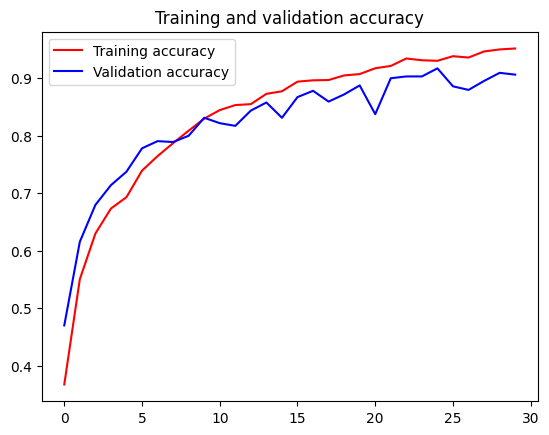

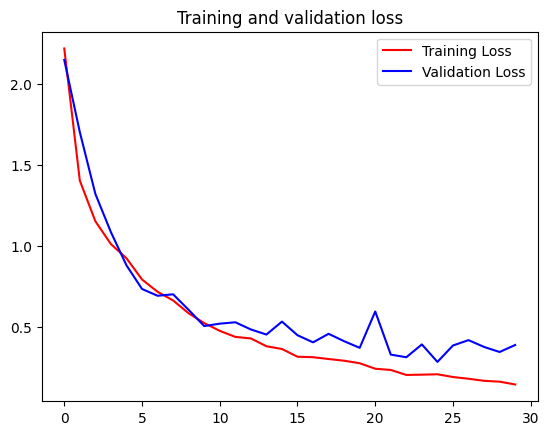

In [13]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing Prediksi

In [17]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
model = load_model('best_model.keras')

In [18]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the test dataset
TESTING_DIR = r'/content/dataset/data/test'

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Create test data generator
testing_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    shuffle=False  # Important to not shuffle for evaluation
)

# Load the best model saved during training
model = load_model('best_model.keras')

# Make predictions
predictions = model.predict(testing_generator)

# Get the class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = testing_generator.classes

# Get the class labels
class_labels = list(testing_generator.class_indices.keys())

# Display results
print("Predicted classes:", predicted_classes)
print("True classes:", true_classes)
print("Class labels:", class_labels)

Found 259 images belonging to 15 classes.
5/5 [==============================] - 5s 838ms/step
Predicted classes: [ 0  0  0  0  0  0  0  0  3  8  0  0  0  0  0  0  0  1  1  1  1  1  4  8
  2 10  1  1  1  1  1  1  1  1  8  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  1  2  2  2  0  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  8  4
  4  4  4  9  4  4  4  4  4  4  4  4  4  4  4  4  5  3  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  1  8  8  8  8
  8  8  8  8  1  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12  9 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 14 14 14 14 13 14 14 14 14 14 14  1 14 14 14 14 14]
True classes: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1
  1  1  1 

In [19]:
test_loss, test_accuracy = model.evaluate(testing_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

5/5 [==============================] - 5s 850ms/step - loss: 0.1885 - accuracy: 0.9344
Test loss: 0.18847623467445374
Test accuracy: 0.9343629479408264


In [28]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import sys
import contextlib

# Path to the test dataset
test_dir = '/content/dataset/data/test'

# List of classes
classes = [
    'Batik Bali', 'Batik Betawi', 'Batik Celup', 'Batik Cendrawasih', 'Batik Dayak', 'Batik Geblek Renteng',
    'Batik Insang', 'Batik Kawung', 'Batik Lasem', 'Batik Mega Mendung', 'Batik Pala', 'Batik Parang',
    'Batik Poleng', 'Batik Sekar Jagad', 'Batik Tambal'
]

# Load the best model saved during training
model = tf.keras.models.load_model('best_model.keras')

@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Initialize lists to store true labels and predictions
true_labels = []
pred_labels = []

# Iterate through each class directory in the test dataset
for motive in classes:
    images_list = os.listdir(os.path.join(test_dir, motive))
    correct_count = 0

    for image in images_list:
        img_path = os.path.join(test_dir, motive, image)
        img = load_img(img_path, target_size=(224, 224))

        # Preprocess the image
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize the image

        # Make prediction
        with suppress_stdout():
            prediction = model.predict(img_array)
        pred_idx = np.argmax(prediction)
        pred_motive = classes[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        # Store true and predicted labels
        true_labels.append(classes.index(motive))
        pred_labels.append(pred_idx)

        if pred_motive == motive:
            correct_count += 1

    total_images = len(images_list)
    print(f'{motive} Predictions --> {correct_count}/{total_images} correct')

Batik Bali Predictions --> 15/17 correct
Batik Betawi Predictions --> 13/18 correct
Batik Celup Predictions --> 17/19 correct
Batik Cendrawasih Predictions --> 16/17 correct
Batik Dayak Predictions --> 16/17 correct
Batik Geblek Renteng Predictions --> 16/17 correct
Batik Insang Predictions --> 17/17 correct
Batik Kawung Predictions --> 17/17 correct
Batik Lasem Predictions --> 16/18 correct
Batik Mega Mendung Predictions --> 18/18 correct
Batik Pala Predictions --> 17/17 correct
Batik Parang Predictions --> 17/17 correct
Batik Poleng Predictions --> 16/16 correct
Batik Sekar Jagad Predictions --> 16/17 correct
Batik Tambal Predictions --> 15/17 correct


# Evaluasi Model

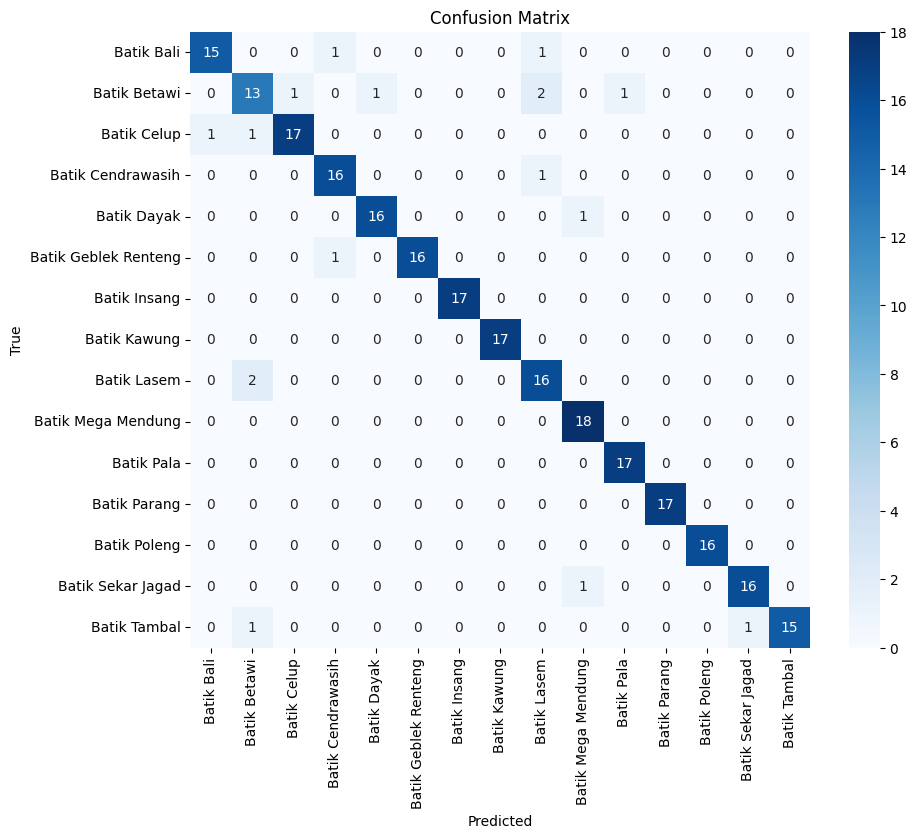

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import itertools
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Calculate precision, recall, F1-score and support
# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=classes)

# Print classification report
print('Classification Report:')
print(report)

# Parse lines to calculate weighted F1-score
lines = report.split('\n')
weighted_f1_score = 0.0
for line in lines[2:-5]:  # Skip header and footer lines
    if line.strip() != '':
        weighted_f1_score += float(line.split()[3])

# Calculate final weighted F1-score
weighted_f1_score /= len(lines[2:-5])

# Print weighted F1-score
print(f'Weighted F1 Score: {weighted_f1_score:.2f}')

Classification Report:
                      precision    recall  f1-score   support

          Batik Bali       0.94      0.88      0.91        17
        Batik Betawi       0.76      0.72      0.74        18
         Batik Celup       0.94      0.89      0.92        19
   Batik Cendrawasih       0.89      0.94      0.91        17
         Batik Dayak       0.94      0.94      0.94        17
Batik Geblek Renteng       1.00      0.94      0.97        17
        Batik Insang       1.00      1.00      1.00        17
        Batik Kawung       1.00      1.00      1.00        17
         Batik Lasem       0.80      0.89      0.84        18
  Batik Mega Mendung       0.90      1.00      0.95        18
          Batik Pala       0.94      1.00      0.97        17
        Batik Parang       1.00      1.00      1.00        17
        Batik Poleng       1.00      1.00      1.00        16
   Batik Sekar Jagad       0.94      0.94      0.94        17
        Batik Tambal       1.00      0.88     

# Import ke Tflite, Json, H5, Tfjs

In [ ]:
# import ke h5

model.save("model.h5")

In [ ]:
# import ke tflite
model = tf.keras.models.load_model("model.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = converter.convert()

# Save the converted model to a .tflite file
with open("CNN_TransferLearningModel.tflite", "wb") as f:
    f.write(model_tflite)

In [ ]:
# import ke json

import json

model = tf.keras.models.load_model("model.h5")

# Save the model architecture to a JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
!pip install tensorflowjs

In [ ]:
# import ke tfjs

model = tf.keras.models.load_model("model.h5")

!tensorflowjs_converter --input_format=keras {saved_model_path} ./
!zip filebin.zip *.bin model.json

# Config

In [ ]:
# model config pake h5
import h5py

# Replace 'your_model_name' with the actual file name of your HDF5 file
file_name = 'model.h5'

# Open the HDF5 file in read mode
with h5py.File(file_name, 'r') as f:
    # Retrieve the 'model_config' attribute
    model_config = f.attrs.get('model_config')

# Print the model configuration
print(model_config)